In [354]:
from matplotlib.pyplot import imread
from tensorflow.python.ops.metrics_impl import mean_absolute_error

# -*- coding: utf-8 -*-
"""
Created on Saturday Nov 15 15:34 2025

@author: 100yearsahead


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


path = "../../coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)
df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year'])

# Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
# df.drop("Date_Year", axis=1, inplace=True)

# df.drop("Realm_Name", axis=1, inplace=True)
# # #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # # For the sake of bigger dataset this feature is dropped
# df.drop("Percent_Cover", axis=1, inplace=True)
# # df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# # df.drop("Temperature_Maximum", inplace=True, axis=1)

# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
# df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
#df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

# df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year' ])
# df = df[df['Bleaching_Level'] != 'Population']
df.drop("Bleaching_Level", axis=1, inplace=True)

# selected_features = ['Country_Name', 'Bleaching_Level', 'TSA', 'Turbidity', 'Realm_Name', 'Ocean_Name', 'ClimSST', 'SSTA', 'Percent_Bleaching']
# df = df[selected_features]
df.dropna(inplace=True)

df.info()
print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [355]:
interactions = [
    # Thermal stress vs physical conditions
    ("TSA", "Depth_m"),                # Shallow reefs may bleach more under thermal stress
    ("TSA", "Distance_to_Shore"),      # Coastal reefs may respond differently to thermal anomalies

    # Water clarity & stress
    ("Turbidity", "Temperature_Mean"), # Murky water + high temps reduce photosynthesis
    ("Turbidity", "Distance_to_Shore"),# Turbidity often higher nearshore


    # Cyclones / physical disturbance
    ("Cyclone_Frequency", "Depth_m"),  # Shallow reefs more impacted by storms
    ("Cyclone_Frequency", "Temperature_Mean"), # Heat stress + cyclone damage interaction
    ("Cyclone_Frequency", "Distance_to_Shore"), # Coastal and open ocean effects

    # Geographical conditions
    ("Depth_m", "Distance_to_Shore"),   # Coastal shallow reefs behave differently
]

for a, b in interactions:
    if a in df.columns and b in df.columns:
       df[f"{a}_x_{b}"] = df[a] * df[b]


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Cyclone_Frequency                      32714 non-null  float64
 1   Depth_m                                32714 non-null  float64
 2   ClimSST                                32714 non-null  float64
 3   Ocean_Name                             32714 non-null  object 
 4   Country_Name                           32714 non-null  object 
 5   Distance_to_Shore                      32714 non-null  float64
 6   Exposure                               32714 non-null  object 
 7   Turbidity                              32714 non-null  float64
 8   Bleaching_Level                        32714 non-null  object 
 9   Temperature_Maximum                    32714 non-null  float64
 10  SSTA                                   32714 non-null  float64
 11  TSA    

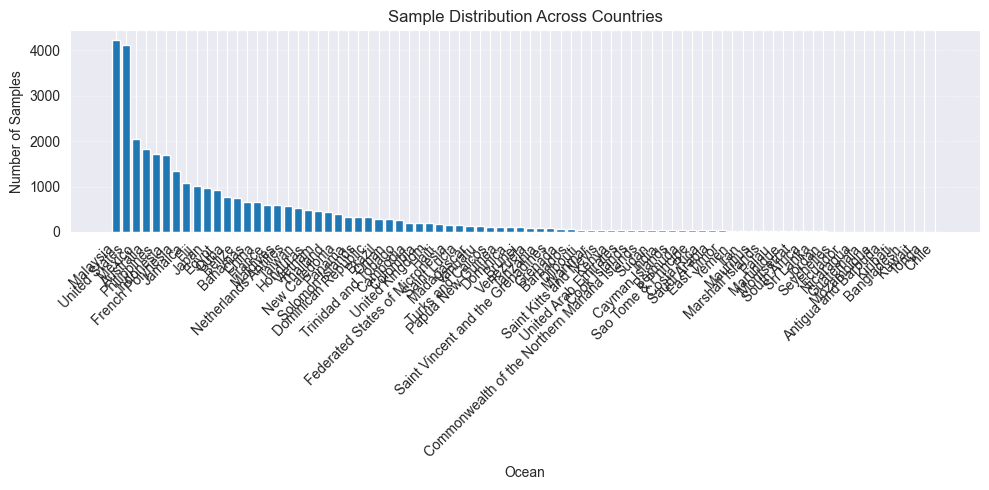

In [356]:
import matplotlib.pyplot as plt

# Count samples per ocean
ocean_counts = df["Country_Name"].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(ocean_counts.index, ocean_counts.values)
plt.xlabel("Ocean")
plt.ylabel("Number of Samples")
plt.title("Sample Distribution Across Countries")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Not only solves skewed data problem, but also removes outliers

In [357]:
def group_normalize(df, value_cols, group_col):
    df_fe = df.copy()

    for col in value_cols:
        df_fe[f"{col}_grp_z"] = (
            df_fe[col] -
            df_fe.groupby(group_col)[col].transform("mean")
        ) / (
            df_fe.groupby(group_col)[col].transform("std") + 1e-6
        )

    return df_fe

min_n = 100
valid_countries = (
    df["Country_Name"]
    .value_counts()
    .loc[lambda x: x >= min_n]
    .index
)

df["Country_group"] = df[("Country_Name")].where(
    df["Country_Name"].isin(valid_countries),
    "Other")


min_n = 100
valid_exposure = (
    df["Exposure"]
    .value_counts()
    .loc[lambda x: x >= min_n]
    .index
)

df["Exposure_group"] = df[("Exposure")].where(
    df["Exposure"].isin(valid_exposure),
    "Other")


df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Cyclone_Frequency                      32714 non-null  float64
 1   Depth_m                                32714 non-null  float64
 2   ClimSST                                32714 non-null  float64
 3   Ocean_Name                             32714 non-null  object 
 4   Country_Name                           32714 non-null  object 
 5   Distance_to_Shore                      32714 non-null  float64
 6   Exposure                               32714 non-null  object 
 7   Turbidity                              32714 non-null  float64
 8   Bleaching_Level                        32714 non-null  object 
 9   Temperature_Maximum                    32714 non-null  float64
 10  SSTA                                   32714 non-null  float64
 11  TSA    

In [337]:
# q25 = df["Distance_to_Shore"].quantile(0.10)
# q50 = df["Distance_to_Shore"].quantile(0.30)
# q75 = df["Distance_to_Shore"].quantile(0.75)
#
# df["Near_Shore"]  = (df["Distance_to_Shore"] <= q25).astype(int)
# df["Mid_Shore"]   = ((df["Distance_to_Shore"] > q25) & (df["Distance_to_Shore"] <= q75)).astype(int)
# df["Far_Shore"]   = (df["Distance_to_Shore"] > q75).astype(int)


In [358]:
import pandas as pd
import numpy as np
from scipy.stats import skew, boxcox
from sklearn.preprocessing import PowerTransformer


numeric_cols = df.select_dtypes(include=[np.number]).columns
skewness_results = {}

for col in numeric_cols:
    clean_data = df[col].dropna()
    if len(clean_data) > 0:
        skew_val = skew(clean_data)
        skewness_results[col] = {
            'skewness': skew_val,
            'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

        }

right_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] > 0.5}
left_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] < -0.5}

print(left_skewed.keys())
print(right_skewed.keys())
for col_right in right_skewed.keys():
    df[col_right] = df[col_right].replace(0, 1e-6)
    df[col_right], lam = boxcox(df[col_right])

for col_left in left_skewed.keys():
    pt = PowerTransformer(method='yeo-johnson')
    df[[col_left]] = pt.fit_transform(df[[col_left]])

skewness_df = pd.DataFrame(skewness_results).T
skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)
skewness_df[:-1]

dict_keys(['ClimSST', 'TSA', 'Temperature_Mean', 'TSA_x_Depth_m', 'TSA_x_Distance_to_Shore'])
dict_keys(['Cyclone_Frequency', 'Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching', 'Turbidity_x_Temperature_Mean', 'Turbidity_x_Distance_to_Shore', 'Cyclone_Frequency_x_Depth_m', 'Cyclone_Frequency_x_Temperature_Mean', 'Cyclone_Frequency_x_Distance_to_Shore', 'Depth_m_x_Distance_to_Shore'])


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,skewness,skew_type
TSA_x_Distance_to_Shore,-32.75368,Left (Negative)
Depth_m_x_Distance_to_Shore,24.59718,Right (Positive)
Cyclone_Frequency_x_Distance_to_Shore,10.95664,Right (Positive)
Distance_to_Shore,9.39048,Right (Positive)
Turbidity_x_Distance_to_Shore,6.86356,Right (Positive)
Turbidity_x_Temperature_Mean,3.85904,Right (Positive)
Turbidity,3.84834,Right (Positive)
Percent_Bleaching,2.96985,Right (Positive)
TSA_x_Depth_m,-2.22601,Left (Negative)
Cyclone_Frequency_x_Depth_m,1.74973,Right (Positive)


In [359]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

df_edit = df.drop(columns=[ ], axis=1)

# Split first (no leakage)
X = df_edit.drop(columns=['Percent_Bleaching'])
y = df_edit['Percent_Bleaching']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Since we have categorical variables we need to seperate the numeric and the categorical variables
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = [col for col in X.columns if col not in num_cols]


# We one_hot_encode the categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])

ohe_feature_names = ohe.get_feature_names_out(cat_cols)



# We scale the numeric features
scaler = StandardScaler()

# Even after normalization its still crucial to scale-up data
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])


# Combine the categorical and numerical features
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed  = np.hstack([X_test_num, X_test_cat])

processed_feature_names = np.concatenate([num_cols, ohe_feature_names])

In [360]:

import tensorflow as ts
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout


nodes_number = int((X_train_processed.shape[1] + 1) * 2/3)
# nodes_number = 74
model = Sequential()
model.add(Input(shape= (X_train_processed.shape[1],)))
model.add(Dense(nodes_number, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(nodes_number, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()



Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 108)            │        17,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 108)            │        11,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │           109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,485 (115.18 KB)

 Trainable params: 29,485 (115.18 KB)

 Non-trainable params: 0 (0.00 B)

Install cuda toolkit for GPU on desktop

Tensorflow GPU version (maybe try conda env)

In [362]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='loss'
)

model.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'],
               )

model.fit(X_train_processed, y_train, epochs=200, verbose=2, callbacks=[early_stop])

model.summary()

Epoch 1/200
818/818 - 1s - 2ms/step - loss: 23.4570 - mae: 3.4586
Epoch 2/200
818/818 - 1s - 980us/step - loss: 23.5054 - mae: 3.4760
Epoch 3/200
818/818 - 1s - 989us/step - loss: 23.3572 - mae: 3.4660
Epoch 4/200
818/818 - 1s - 986us/step - loss: 23.1500 - mae: 3.4389
Epoch 5/200
818/818 - 1s - 983us/step - loss: 23.0876 - mae: 3.4456
Epoch 6/200
818/818 - 1s - 980us/step - loss: 23.3939 - mae: 3.4586
Epoch 7/200
818/818 - 1s - 981us/step - loss: 23.2332 - mae: 3.4519
Epoch 8/200
818/818 - 1s - 979us/step - loss: 23.0699 - mae: 3.4375
Epoch 9/200
818/818 - 1s - 979us/step - loss: 23.0290 - mae: 3.4313
Epoch 10/200
818/818 - 1s - 979us/step - loss: 23.0376 - mae: 3.4288
Epoch 11/200
818/818 - 1s - 986us/step - loss: 23.1649 - mae: 3.4398
Epoch 12/200
818/818 - 1s - 990us/step - loss: 23.1631 - mae: 3.4329
Epoch 13/200
818/818 - 1s - 988us/step - loss: 23.1189 - mae: 3.4346
Epoch 14/200
818/818 - 1s - 981us/step - loss: 23.0768 - mae: 3.4419
Epoch 15/200
818/818 - 1s - 990us/step - loss

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 108)            │        17,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 108)            │        11,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │           109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,457 (345.54 KB)

 Trainable params: 29,485 (115.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,972 (230.36 KB)

In [363]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred = model.predict(X_test_processed)

score = r2_score(y_test, y_pred)

print(score)
print(mean_absolute_error(y_test, y_pred))

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
0.6140984247677721
3.614938435659671


In [30]:
from keras import Sequential

# -*- coding: utf-8 -*-
"""
Created on Wed Oct 29 15:40:04 2025

@author: zemsk


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
import os


path = "../../coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral.csv")

df = pd.read_csv(filename_read)

# # Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
# df.drop("Date_Year", axis=1, inplace=True)
# df.drop("Bleaching_Level", axis=1, inplace=True)
# df.drop("Realm_Name", axis=1, inplace=True)
#
# cols_to_drop = [
#     'Site_ID', 'Data_Source', 'Latitude_Degrees', 'Longitude_Degrees',
#     'Reef_ID', 'Ecoregion_Name', 'State_Island_Province_Name',
#     'City_Town_Name', 'Site_Name', 'Date', 'Date_Day', 'Date_Month',
#     'Site_Comments', 'Sample_Comments', 'Bleaching_Comments'
# ]
#
# df.drop(cols_to_drop, axis=1, inplace=True)
# #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # For the sake of bigger dataset this feature is dropped
# df.drop("Percent_Cover", axis=1, inplace=True)
# df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# df.drop("Temperature_Maximum", inplace=True, axis=1)
#
# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
#df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
# df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

df.dropna(inplace=True)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                41361 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41361 non-null  object 
 9   Country_Name                           41361 non-null  object 
 10  State_Island_Province_Name             41361 non-null  object 
 11  Ci

C:\Users\zemsk\AppData\Local\Temp\ipykernel_37696\926067815.py:26: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename_read)


In [116]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model,
    X_test_processed,
    y_test,
    n_repeats=2,
    random_state=42,
    scoring="neg_mean_absolute_error"
)



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
65/65 ━━━━━━━━━━

In [127]:
importance = result.importances_mean

# Feature importance
importance_df = pd.DataFrame({
    "feature": processed_feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

def get_base_feature(feature_name):
    for col in num_cols + cat_cols :
        if feature_name.startswith(col):
            return col
    return feature_name.split("_")[0]

importance_df["base_feature"] = importance_df["feature"].apply(get_base_feature)

grouped_importance = (
    importance_df
    .groupby("base_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)

grouped_importance = grouped_importance / grouped_importance.sum()

threshold = 0.02
selected_features_tree = [
    f for f, s in zip(grouped_importance.index, grouped_importance.values)
    if s > threshold  # likely you want important features
]
print(f"Selected features for trees: {selected_features_tree}")
grouped_importance

Selected features for trees: ['Temperature_Mean', 'TSA', 'Country_Name', 'Country_group', 'Cyclone_Frequency', 'Turbidity', 'ClimSST', 'SSTA', 'Exposure', 'Depth_m', 'Distance_to_Shore']


base_feature
Temperature_Mean      0.15847
TSA                   0.13254
Country_Name          0.12633
Country_group         0.10649
Cyclone_Frequency     0.09312
Turbidity             0.08405
ClimSST               0.07754
SSTA                  0.07284
Exposure              0.06315
Depth_m               0.02904
Distance_to_Shore     0.02768
Realm_Name            0.01984
Ocean_Name            0.00890
Bleaching_Level       0.00000
Temperature_Maximum   0.00000
Name: importance, dtype: float64